Каждый агент начинает со случайного мнения и среднего уровня неопределенности, за исключением нескольких "экстремистов", тех, кто имеет самые положительные или отрицательные мнения и очень низкий уровень неопределенности. Постройте агентную модель и убедитесь, что в этих условиях экстремизм распространяется, и в конечном итоге симуляция достигает устойчивого состояния, когда все агенты присоединяются к экстремистам на том или другом конце континуума мнений. Без определенных экстремистов агенты приходят к среднему мнению. Таким образом, модель показывает, что несколько экстремистов с ярко выраженными мнениями могут оказать существенное влияние на мнение большинства.

Deffuant G., Amblard F., Weisbuch G., Faure T. How Can Extremism Prevail? A Study Based on the Relative Agreement Interaction Model // Journal of Artificial Societies and Social Simulation. – 2002. – Vol. 5. – N 4.
http://jasss.soc.surrey.ac.uk/5/4/1.htmlLinks to an external site.

1) Реализовать модель парного взаимодействия. Реализовать модель все-со-всеми. (2 балла)
2) Оценить сходимость модели. (4 балла)
3) Реализовать ML модель предсказания числа кластеров (или иного показателя, введенного в п.2) (4 балла)

In [241]:
from mesa import Agent, Model
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %load_ext autoreload

# 1 Модель

Реализация самой модели сохранена в `main.py`

Характер взаимодействия (парное или все-со-всеми) регулируется параметром модели `pairwise`

In [242]:
%autoreload 1
%aimport main

Посмотрим, работает ли модель вообще

Попарная

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1611.39it/s]


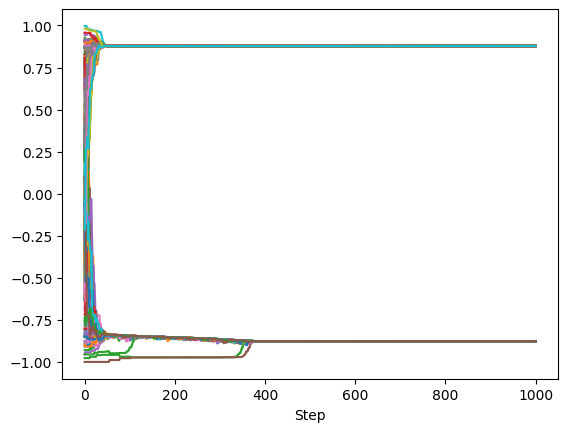

In [284]:
model1 = main.PolicitalModel(N=200, 
                             u=1.2,
                             u_e=0.1,
                             p_e=0.25,
                             mu=0.5,
                             delta=0,
                             pairwise=True,)

for _ in tqdm(range(1000)):
    model1.step()
    
ex_data = model1.datacollector.get_agent_vars_dataframe().T.stack().T
ex_data.plot(legend=False)
plt.show();

In [285]:
ex_agents = pd.DataFrame([(i.x, i.u, i.unique_id, i.extremist) for i in model1.agents], columns=['X', 'U', 'Id', 'Extr'])

ex_agents.groupby(ex_agents.X.round(3)).Id.count()

X
-0.876     95
 0.878    105
Name: Id, dtype: int64

100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 66.18it/s]


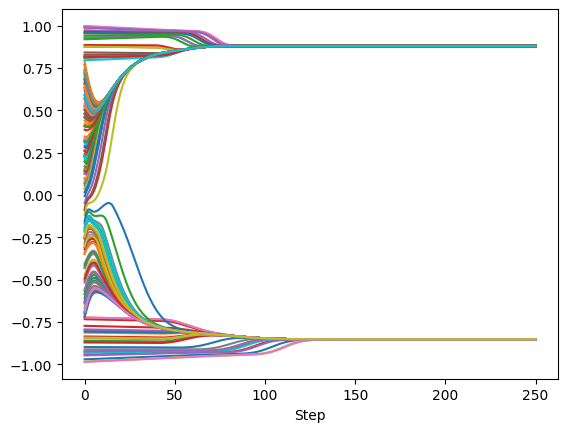

In [286]:
model2 = main.PolicitalModel(N=200, 
                             u=1.2,
                             u_e=0.1,
                             p_e=0.25,
                             mu=0.5,
                             delta=0,
                             pairwise=False,)

for _ in tqdm(range(250)):
    model2.step()
    
ex_data2 = model2.datacollector.get_agent_vars_dataframe().T.stack().T
ex_data2.plot(legend=False)
plt.show();

In [289]:
ex_agents2 = pd.DataFrame([(i.x, i.u, i.unique_id, i.extremist) for i in model2.agents], columns=['X', 'U', 'Id', 'Extr'])

ex_agents2.groupby(ex_agents2.X.round(3)).Id.count()

X
-0.853     74
 0.880    126
Name: Id, dtype: int64

Окей, вроде оба варианта рабочие

Как мы видим сразу, вторая ожидаемо сходится "плавнее", тк мнение агента корректируется на среднее по больнице 

# 2 Сходимость

In [267]:
# ex_agents = pd.DataFrame([(i.x, i.u, i.unique_id) for i in model.agents], columns=['X', 'U', 'Id'])

# ex_agents[ex_agents.X.abs() < 0.4]

In [213]:
starter_model = PolicitalModel(10)
# starter_model.step()

In [28]:
# from itertools import combinations

# array = model.schedule.agents

# pairs = combinations(array, 2)

# len(pairs)

In [24]:
# model.schedule

In [25]:
model.run_model()

KeyboardInterrupt: 

In [41]:
from tqdm import tqdm

In [170]:
model = main.PolicitalModel(N=1000, pairwise=False)

# for i in tqdm(range(1050)):
#     model.step()

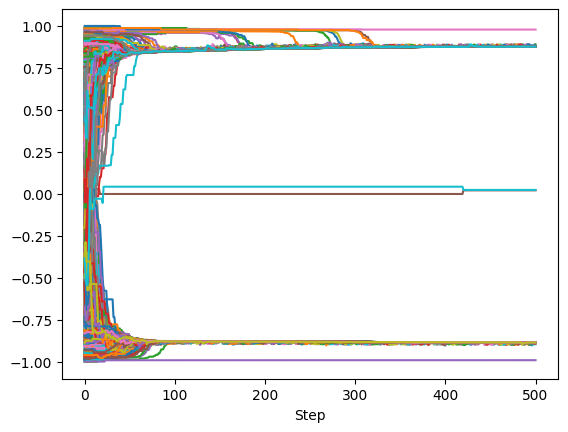

In [79]:
opinion_data = model.datacollector.get_agent_vars_dataframe().T.stack().T
opinion_data.plot(legend=False)
plt.show();

In [75]:
# [abs(i.x) < 0.5 for i in model.agents]

In [77]:
model.datacollector.get_agent_vars_dataframe()

X  Change
Step AgentID                  
0    0        0.830675       0
     1        0.235970       0
     2       -0.970068       0
     3        0.785891       0
     4       -0.873625       0
...                ...     ...
500  105      0.875720       0
     762      0.876111       0
     922      0.875319       0
     533      0.875230       0
     474     -0.884167       0

[501000 rows x 2 columns]

In [215]:
# for i in a:
#     time.sleep(1)

In [201]:
model = main.PolicitalModel(N=300, pairwise=True, change_threshold=10**(-7))

# for i in tqdm(range(2000)):
#     model.step()

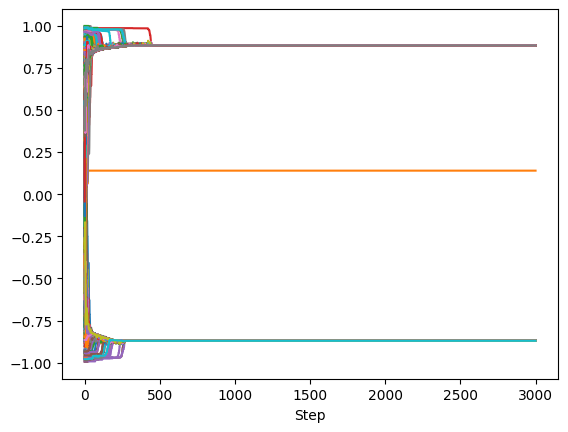

In [226]:
model = main.PolicitalModel(N=1000, pairwise=True, change_threshold=0, max_iter=1000)

# for i in tqdm(range(2000)):
#     model.step()
model.run(progress_bar=True)
opinion_data = model.datacollector.get_agent_vars_dataframe()[['X']].T.stack().T
opinion_data.plot(legend=False)
plt.show();

In [222]:
model.schedule.steps

352

In [143]:
10**(-7)

1e-07

In [146]:
change_data[change_data.values < 1e-07]

,Step_sum_change
732,8.662370e-08
733,8.100652e-08
734,7.118264e-08
735,5.552239e-08
736,5.315417e-08
...,...
1995,5.329071e-15
1996,5.995204e-15
1997,6.217249e-15
1998,6.439294e-15


In [132]:
change_data = model.model_datacollector.get_model_vars_dataframe() #[900:1600].plot();

In [131]:
model.model_datacollector.get_model_vars_dataframe()[900:].values[0] < 0.000001

array([ True])

In [86]:
change_data = model.datacollector.get_agent_vars_dataframe()[['Change']]

In [89]:
change_data.reset_index().groupby('Step')

,Step,AgentID,Change
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
1000995,1000,901,0
1000996,1000,838,0
1000997,1000,695,0
1000998,1000,226,0


In [266]:
print(model.agents[25])

In [15]:
b = model.agents[0]

In [16]:
a == b

False

In [216]:
# starter_model.datacollector.get_agent_vars_dataframe()

In [150]:
pairs = np.random.choice(starter_model.schedule.agents, size=(int(len(a_lis) / 2), 2),replace=False)

In [12]:
model.schedule.agents

In [127]:
(int(len(a_lis) / 2), 2)

(5, 2)

In [146]:
np.random.choice([i for i in a_lis], size=(int(len(a_lis) / 2), 2),replace=False)

array([[<__main__.PoliticalAgent object at 0x137ca7910>,
        <__main__.PoliticalAgent object at 0x137ca5ff0>]], dtype=object)

In [131]:
# starter_model.schedule.step()